In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [17]:
df = pd.read_csv("dataset.csv")   # Adjust if your CSV is in different folder
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [18]:
print(df.isnull().sum())
df = df.dropna()   # Simple cleanup for now
print("After dropping NA:", df.shape)

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64
After dropping NA: (2011, 10)


In [19]:
X = df.drop("Potability", axis=1)   # Features = water quality params
y = df["Potability"]               # Target = 0 (Not potable) / 1 (Potable)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [21]:
!pip install xgboost


In [22]:
!python.exe -m pip install --upgrade pip

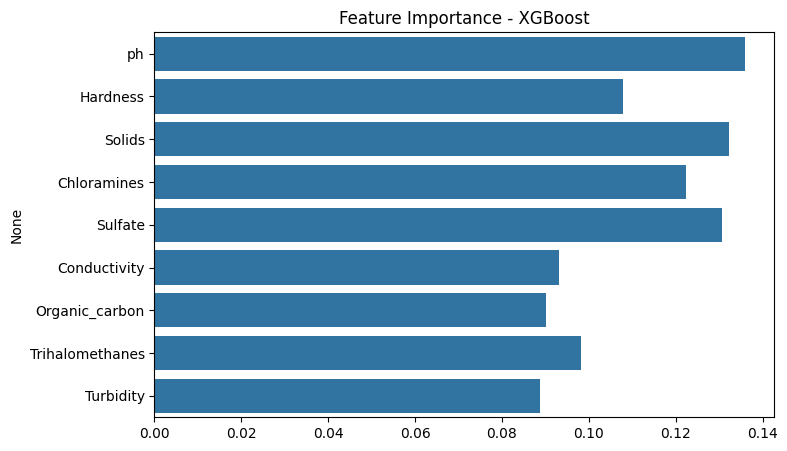

In [23]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=model.feature_importances_,
    y=X.columns
)
plt.title("Feature Importance - XGBoost")
plt.show()


In [27]:
import folium

# For demo, generate fake lat/lon in India
villages = pd.DataFrame({
    "Village": ["A","B","C","D","E","F","G","H","I","J"],
    "Latitude": np.random.uniform(20, 28, 10),   # Northern India range
    "Longitude": np.random.uniform(72, 88, 10),  # Roughly east-west
})

# Predict risk for each village (using avg water quality for now)
villages["Risk_Score"] = np.random.choice([0,1], size=10, p=[0.5,0.5])

# Map
m = folium.Map(location=[23,80], zoom_start=5)

for _, row in villages.iterrows():
    color = "green" if row["Risk_Score"]==0 else "red"
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=8,
        color=color,
        fill=True,
        popup=f"Village: {row['Village']} | Risk: {row['Risk_Score']}"
    ).add_to(m)

m


In [25]:
!pip install folium



   -------------------------- ------------- 2/3 [folium]
   ---------------------------------------- 3/3 [folium]



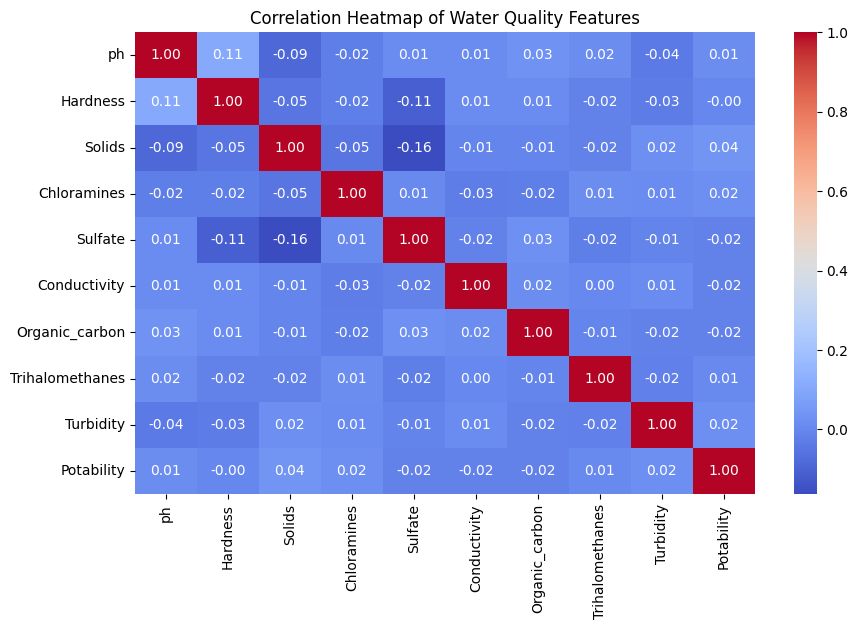

In [28]:
# ===============================================
# Extra EDA - Correlation Heatmap
# ===============================================
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Water Quality Features")
plt.show()


C:\Users\Dhruv\OneDrive\Desktop\water_borne_prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.60
Random Forest Accuracy: 0.70
SVM Accuracy: 0.60


C:\Users\Dhruv\OneDrive\Desktop\water_borne_prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:14:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.65


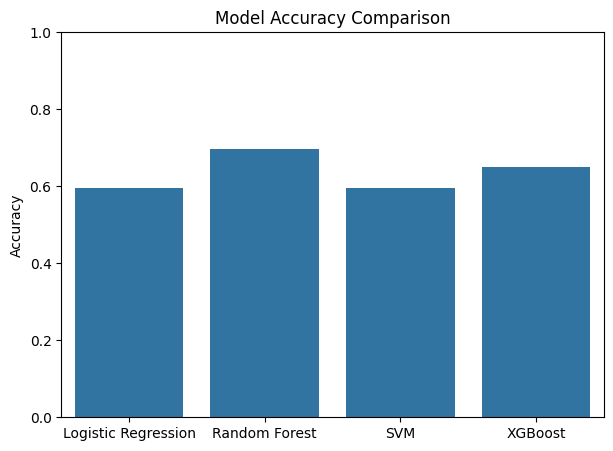

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

results = {}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2f}")

# Accuracy bar chart
plt.figure(figsize=(7,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


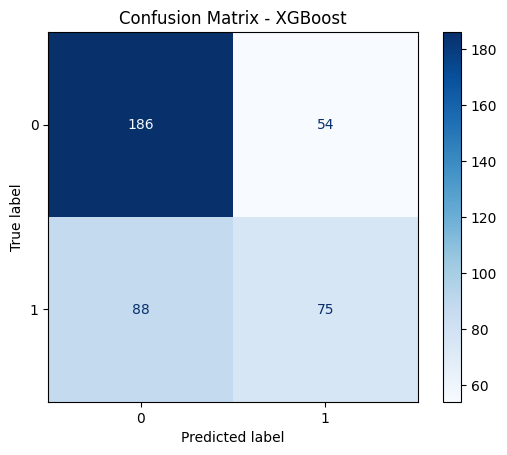

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()
